In [66]:
%matplotlib inline

import math

import numpy as np
import pandas as pd

import arviz as az

import matplotlib.pyplot as plt
import plotly
import plotly.figure_factory as ff

import scipy.stats

import logging

from datetime import date
import os

## Simulate Data

In [2]:
import importlib
import simulate_data
importlib.reload(simulate_data)

<module 'simulate_data' from '/Users/hwunrow/Documents/GitHub/rt-estimation/src/simulate_data.py'>

In [3]:
true_params = {
    'rt_0': 1.4,
    'rt_1': 3.,
    'midpoint': 100.,
    'k': 0.1,
    'n_t': 365,
    't_I': 4.,
    'N': 100_000.,
    'S0': 99_900.,
    'I0': 100.,
}


np.random.seed(1994)

# data = simulate_data.simulate_data(**true_params, run_deterministic=True)

data = simulate_data.simulate_data(**true_params, add_noise=True, noise_param=1/50)

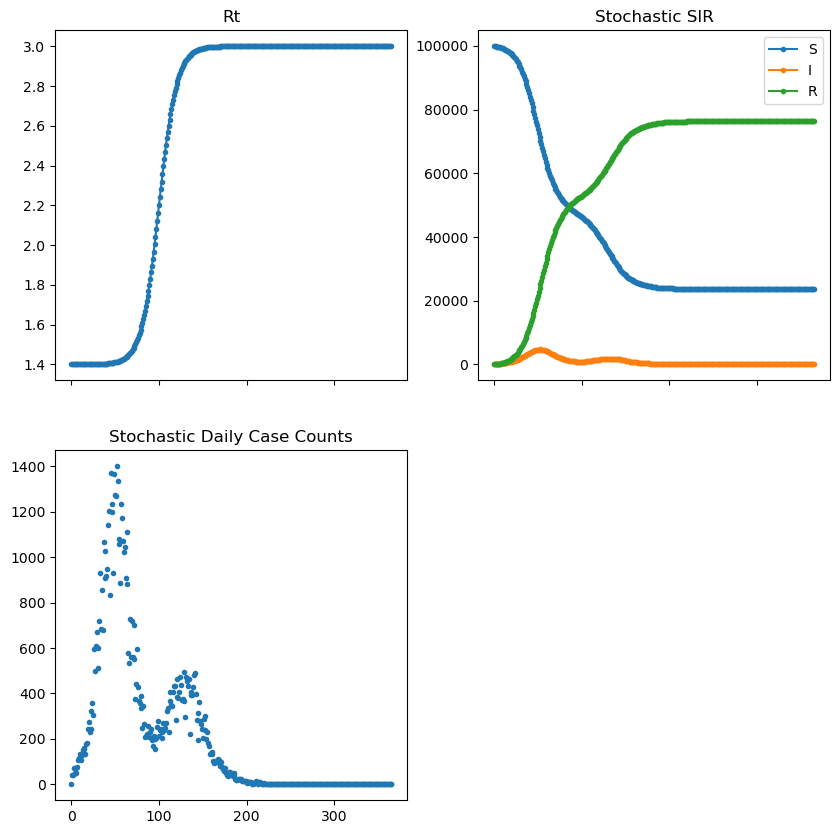

In [4]:
data.plot_all()

## Metropolis Hastings

0. Initialize $\theta_0 \sim p(\theta)$
1. For each iteration `t=0:num_burn_in+num_draws`
    * Generate candidate $\theta^\prime \sim \mathcal{N}(\theta_t, \sigma=2)$ **fixed step size**
    * Acceptance ratio $r = \min\left(1, \frac{p(\theta^\prime)p(x|\theta^\prime)}{p(\theta_t)p(x|\theta_t)}\right) $
        - Equivalently in log space
         $
         \log(r) = \min\left(0, \log p(\theta^\prime) + \log p(x|\theta^\prime) - \log p(\theta_t) - \log p(x|\theta_t)\right)
         $
    * Accept/ reject
        - $u \sim U[0,1]$
        - If $\log(u) \leq \log(r)$, then *accept*, i.e., $\theta_{t+1} = \theta^\prime$
        - Otherwise $\log(u) > \log(r)$, then *reject*, i.e., $\theta_{t+1} = \theta_{t}$

In [5]:
## unset seed
np.random.seed()

In [9]:
from scipy.stats import uniform
from scipy.stats import randint
from scipy.stats import poisson
from scipy.stats import multivariate_normal
from scipy.stats import norm

In [10]:
n_t = 365
t = np.arange(n_t)
t_I = 4.
N = 100_000

In [126]:
def halfcauchy(x,beta):
    if x < 0:
        raise ValueError("x must be positive")
    if beta < 0:
        raise ValueError("beta must be positive")
        
    return 2/(np.pi*beta*(1+(x/beta)**2))

def sample_new(rt_0, rt_1, k, midpoint, I0, scale=2):
    new_draw = multivariate_normal(mean=np.array([rt_0[0], rt_1[0], k[0], midpoint[0], I0[0]]), cov=np.diag(np.repeat(scale,5))).rvs(1)
    return new_draw[0], new_draw[1], new_draw[2], new_draw[3], new_draw[4]

def sample_new_midpoint(midpoint, scale=2):
    new_draw = norm(loc=midpoint, scale=scale).rvs(1)
    return int(new_draw[0])

def random_coin(p):
    unif = np.random.uniform(0,1)
    if unif>=p:
        return False
    else:
        return True

def log_random_coin(logp):
    unif = np.random.uniform(0,1)
    if np.log(unif)>=logp:
        return False
    else:
        return True

def integrate(rt_0, rt_1, k, midpoint, I0, t_I, N, S0, n_t):
    t = np.arange(365)
    rt = rt_0 + (rt_1 - rt_0) / (1. + np.exp(-k*(t - midpoint)))
    beta = rt / t_I
    S = np.array([S0])
    Ir = np.array([I0])
    R = np.array([0])
    i = np.array([0])
    for t in range(n_t):
        dSI = np.random.poisson(beta[t]*Ir[t]*S[t]/N)
        dIR = np.random.poisson(Ir[t]/t_I)

        S_new = np.clip(S[t]-dSI, 0, N)
        I_new = np.clip(Ir[t]+dSI-dIR, 0, N)
        R_new = np.clip(R[t]+dIR, 0, N)

        S = np.append(S, S_new)
        Ir = np.append(Ir, I_new)
        R = np.append(R, R_new)
        i = np.append(i, dSI)

    return S, Ir, R, i


def logprior_prob(rt_0, rt_1, k, midpoint, I0):
    p_rt_0 = uniform(loc=1., scale=3.).logpdf(rt_0)
    p_rt_1 = uniform(loc=1.5, scale=2.5).logpdf(rt_1)
    p_k = uniform(loc=0.01, scale=1.99).logpdf(k)
    p_midpoint = randint(low=30, high=200).logpmf(midpoint)
    p_I0 = poisson(50).logpmf(I0)
    
    prob = np.sum([p_rt_0, p_rt_1, p_k, p_midpoint, p_I0])
    
    return prob

def loglike_prob(i, data=data.i):
    # prob = multivariate_normal(mean=i[1:], cov=np.diag((1+0.2*i[1:])**2)).logpdf(data[1:])
    prob = norm(loc=i[1:], scale=np.abs(1+0.2*i[1:])).logpdf(data[1:])
    prob = np.sum(prob)
    return prob
    
    
def metropolis_hastings(burn_in, draws):
    i_list = []
    chain = []
    accept_list = []
    accept_prob_list = []
    
    # rt_0 = true_params['rt_0']
    # rt_1 = true_params['rt_1']
    # k = true_params['k']
    rt_0 = uniform(loc=1., scale=3.).rvs(1)
    rt_1 = uniform(loc=1.5, scale=2.5).rvs(1)
    k = uniform(loc=0.01, scale=1.99).rvs(1)
    midpoint = randint(low=30, high=200).rvs(1)
    I0 = poisson(50).rvs(1)
    # I0 = true_params['I0']
    
    S0 = N - I0
    
    current = {
        "rt_0": rt_0,
        "rt_1": rt_1,
        "k": k,
        "midpoint": midpoint,
        "I0": I0,
    }
    chain.append(current)
    
    accept = 1

    from tqdm import tqdm
    
    for iter in tqdm(range(burn_in+draws)):
        
        if accept == 1:
            _, _, _, i = integrate(rt_0, rt_1, k, midpoint, I0, t_I, N, S0, n_t)
        
        i_list.append(i)
        # import pdb; pdb.set_trace()
        rt_0_new, rt_1_new, k_new, midpoint_new, I0_new = sample_new(rt_0, rt_1, k, midpoint, I0)
        # midpoint_new = sample_new_midpoint(midpoint)
        _, _, _, i_new = integrate(rt_0, rt_1, k, midpoint_new, I0, t_I, N, S0, n_t)
        
        loglike = loglike_prob(i)
        logprior = logprior_prob(rt_0, rt_1, k, midpoint, I0)
        curr_prob = logprior + loglike
        
        logprior_new = logprior_prob(rt_0, rt_1, k, midpoint_new, I0)
        loglike_new = loglike_prob(i_new)
        move_prob = logprior_new + loglike_new
        # print(f"proposed: {midpoint_new}, log prior: {prior_new}, like_new: {like_new}")
        
        logacceptance = np.minimum(move_prob - curr_prob, 0.)
        accept_prob_list.append(logacceptance)

        if log_random_coin(logacceptance):
            current = {
                "rt_0": rt_0,
                "rt_1": rt_1,
                "k": k,
                "midpoint": midpoint_new,
                "I0": I0,
            }
            rt_0 = rt_0_new
            rt_1 = rt_1_new
            k = k_new
            midpoint = midpoint_new
            I0 = I0_new
            accept = 1
            accept_list.append(accept)
        else:
            accept = 0
            accept_list.append(accept)
            
        chain.append(current)
    
    return chain[burn_in:], chain[:burn_in], accept_list, accept_prob_list, np.array(i_list)

In [127]:
trace, burn_in, accept_list, accept_prob_list, i = metropolis_hastings(burn_in=1000, draws=5000)

  0%|                                                                                                                                                                             | 0/6000 [00:00<?, ?it/s]/opt/anaconda3/envs/rt-estimation/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6000/6000 [01:51<00:00, 53.96it/s]


In [128]:
np.mean(accept_list[1000:])

0.0

In [129]:
burn_in_df = pd.DataFrame(burn_in)

In [130]:
df = pd.DataFrame(trace)

In [131]:
df.mean()

rt_0          1.646226
rt_1          3.063274
k             1.676761
midpoint    174.000000
I0           58.000000
dtype: float64

In [134]:
df.midpoint()

TypeError: 'Series' object is not callable

ValueError: zero-size array to reduction operation minimum which has no identity

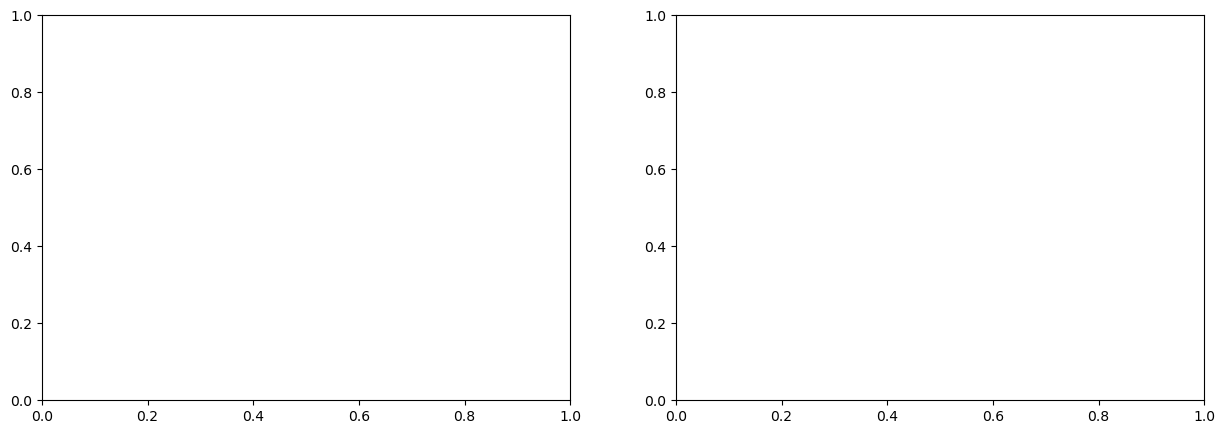

In [132]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

d = np.diff(np.unique(df.midpoint)).min()
left_of_first_bin = df.midpoint.min() - float(d)/2
right_of_last_bin = df.midpoint.max() + float(d)/2

ci = az.hdi(np.array(df.midpoint), alpha=0.94)

df.midpoint.plot.hist(ax=ax[0], bins=np.arange(left_of_first_bin, right_of_last_bin + d, d), density=True, color='lightblue')
ax[0].axvline(x = true_params['midpoint'], color = 'black', alpha=0.5, linestyle = '-', label='truth')
ax[0].hlines(y = 0.001, xmin = ci[0], xmax = ci[1], color='r', linewidth=4, label='94% HDI')
ax[0].set_title('Midpoint Posterior')
ax[0].legend()

ax[1].plot(np.arange(0,1000), burn_in_df.midpoint, color='grey', label = 'burn in')
ax[1].plot(np.arange(999,6000), df.midpoint, color='lightblue', label = 'trace')
ax[1].axhline(y = true_params['midpoint'], color = 'black', alpha=0.5, linestyle = '-', label='truth')
ax[1].set_title('Midpoint Trace Plot')
ax[1].legend()

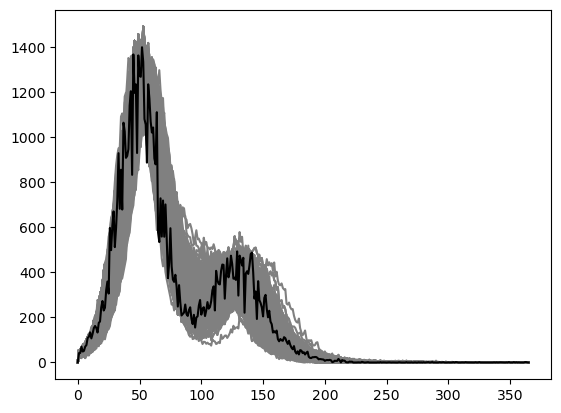

In [90]:
plt.plot(i[1000:,].T, color='grey')
plt.plot(data.i, color='black', label='obs')

In [94]:
from random import choices

ppc = choices(trace, k=1000)

i_ppc_list = []
for theta in ppc:
    S0 = N - theta['I0']
    _, _, _, i = integrate(t_I=true_params['t_I'], N=true_params['N'], S0=S0, n_t=true_params['n_t'], **theta)
    i_ppc_list.append(i)

In [95]:
i_ppc = np.array(i_ppc_list)

In [100]:
i_ppc = i_ppc[:,1:]

[Text(0.5, 1.0, 'Posterior Predictive HDI SIR Model')]

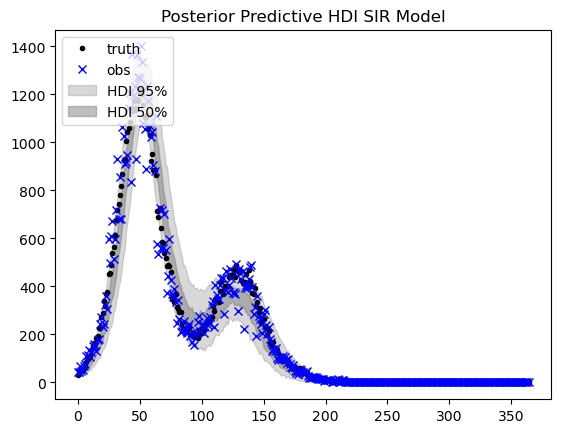

In [102]:

fig, ax = plt.subplots()
t = range(n_t)

ax.plot(t, data.i_true[1:], '.', label="truth", color='black')
ax.plot(t, data.i[1:], 'x', label="obs", color='blue')

az.plot_hdi(
    x=t,
    y=i_ppc,
    hdi_prob=0.95,
    color="gray",
    smooth=False,
    fill_kwargs={"label": "HDI 95%", "alpha": 0.3},
    ax=ax,
)
az.plot_hdi(
    x=t,
    y=i_ppc,
    hdi_prob=0.5,
    color="gray",
    smooth=False,
    fill_kwargs={"label": "HDI 50%", "alpha": 0.5},
    ax=ax,
)
ax.legend(loc="upper left")
ax.set(title="Posterior Predictive HDI SIR Model")


In [104]:
i_ppc.shape

(1000, 365)

In [108]:
ci_95 = az.hdi(i_ppc, hdi_prob=0.95)
ci_50 = az.hdi(i_ppc, hdi_prob=0.5)
prop_95 = np.mean((ci_95[:, 0] <= data.i[1:]) & (data.i[1:] <= ci_95[:, 1]))
prop_50 = np.mean((ci_50[:, 0] <= data.i[1:]) & (data.i[1:] <= ci_50[:, 1]))
print(f"Percent of observations in 95% CI {round(prop_95*100, 2)}%")
print(f"Percent of observations in 50% CI {round(prop_50*100, 2)}%")

Percent of observations in 95% CI 75.34%
Percent of observations in 50% CI 38.08%


/var/folders/zn/k_h7_jyn53z2q5c6jyqhbsym0000gn/T/ipykernel_71297/641099653.py:1: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  ci_95 = az.hdi(i_ppc, hdi_prob=0.95)
/var/folders/zn/k_h7_jyn53z2q5c6jyqhbsym0000gn/T/ipykernel_71297/641099653.py:2: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  ci_50 = az.hdi(i_ppc, hdi_prob=0.5)


### Figure out how the hell PyMC is calculating likelihoods

In [25]:


loglike_prob(i)

-790298.5758905652

In [133]:
import pymc as pm
import pytensor
import pytensor.tensor as pt

def compute_loglikelihood(i):
    t = np.arange(0, 365)
    coords = {'day':t}
    with pm.Model(coords=coords) as likelihood_sampler:
        normal = pm.MvNormal(
            "like_normal",
            mu=i[1:],
            cov=np.diag((1+0.2*i[1:])**2),
            dims="day"
        )
    return likelihood_sampler.compile_logp()({'like_normal': data.i[1:]})

In [134]:
compute_loglikelihood(i)

array(-3400296.51916413)

In [135]:
t = np.arange(0, 365)
coords = {'day':t}
with pm.Model(coords=coords) as likelihood_sampler:
    normal = pm.MvNormal(
        "like_normal",
        mu=i[1:],
        cov=np.diag((1+0.2*i[1:])**2),
        dims="day"
    )

In [136]:
pm.logp(normal, data.i[1:]).eval()

array(-3400296.51916413)

Things are consistent between PyMC and my janky code when using `pm.MvNormal`

In [137]:
def like_prob_univariate(i, data=data.i):
    prob = norm(loc=i[1:], scale=(1+0.2*i[1:])).logpdf(data[1:])
    return prob

In [138]:
np.sum(like_prob_univariate(i))

-3400296.5191641324

In [139]:
t = np.arange(0, 365)
coords = {'day':t}
with pm.Model(coords=coords) as likelihood_sampler:
    normal = pm.Normal(
        "like_normal",
        mu=i[1:],
        sigma=np.abs(1+0.2*i[1:]),
        dims="day"
    )

In [140]:
np.sum(pm.logp(normal, data.i[1:]).eval())

-3400296.5191641324